In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


### Load the data

In [2]:
# Load JSON data into a DataFrame
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
print('originl shape:', df.shape) #original dataset is very large to work with on a project like this one, so I will use a smaller subset of this dataset
df = df.sample(frac = 0.02, random_state=42).reset_index(drop=True)  #reduced the dataframe to a smaller fraction to use a the dataset
print('new shape:', df.shape)

originl shape: (209527, 6)
new shape: (4191, 6)


In [3]:
df = df.drop(columns= ['link', 'short_description', 'authors']) # drop the unnecessary columns
df.head(5)

,headline,category,date
0,What If We Were All Family Generation Changers?,IMPACT,2014-06-20
1,Firestorm At AOL Over Employee Benefit Cuts,BUSINESS,2014-02-08
2,Dakota Access Protesters Arrested As Deadline ...,POLITICS,2017-02-22
3,One Glimpse Of These Baby Kit Foxes And You'll...,GREEN,2014-05-14
4,"Mens' Sweat Pheromone, Androstadienone, Influe...",SCIENCE,2013-06-02


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   headline  4191 non-null   object        
 1   category  4191 non-null   object        
 2   date      4191 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 98.4+ KB


In [5]:
#total number of categories in this dataset
df.value_counts('category').shape # number of categories in the original dataset

(42,)

### Choose a subset of the original dataset 

In [6]:
#we will only use the top 6 categories
top_categories = df['category'].value_counts().nlargest(6).index.tolist()
df = df[df['category'].isin(top_categories)].reset_index(drop=True)
df.value_counts('category').shape # number of categories 

(6,)

### Proportion of Each category in the dataset

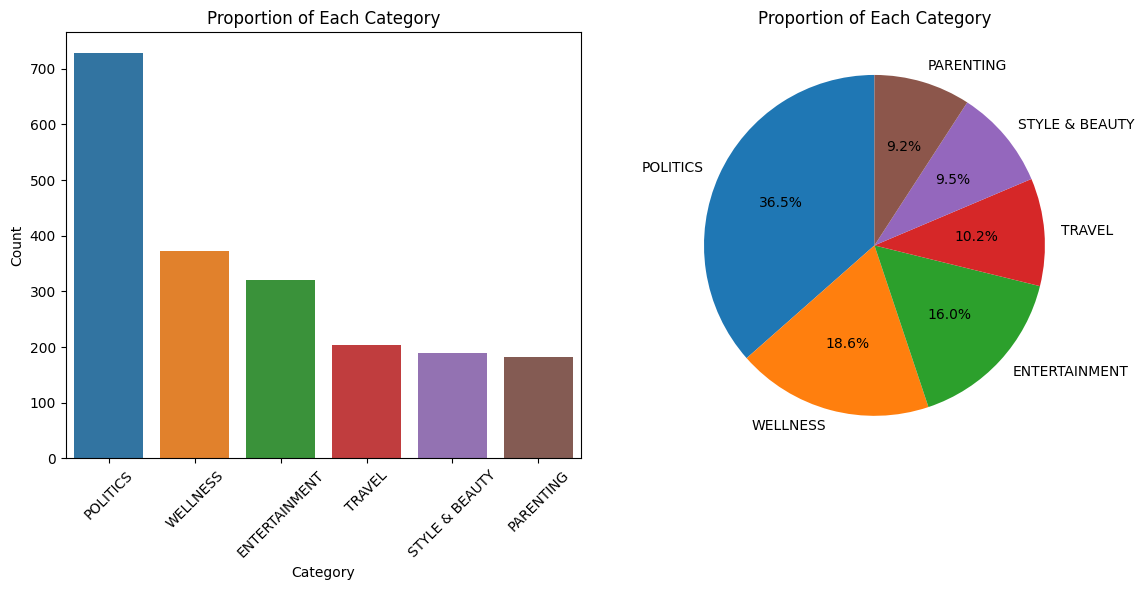

In [7]:
category_counts = df['category'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bar chart on the first axis
sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[0])
axes[0].set_title('Proportion of Each Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45, labelrotation=45, right=True)  # Rotate x-axis labels for better visibility

# Pie chart on the second axis
axes[1].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Proportion of Each Category')

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined figure
plt.show()



### Histogram and word cloud based on the word length of the headlines 

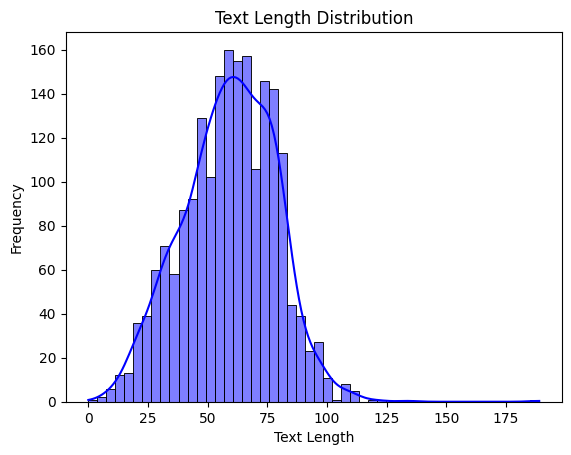

In [8]:
df['text_length'] = df['headline'].apply(len)

# Plot a histogram
plt.figure()
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Top 10 words by frequency:
       Word  Frequency
919   trump        213
672  photos        135
615     new         83
247  donald         68
935   video         50
203     day         46
776    says         45
627   obama         42
84     best         38
355     gop         38


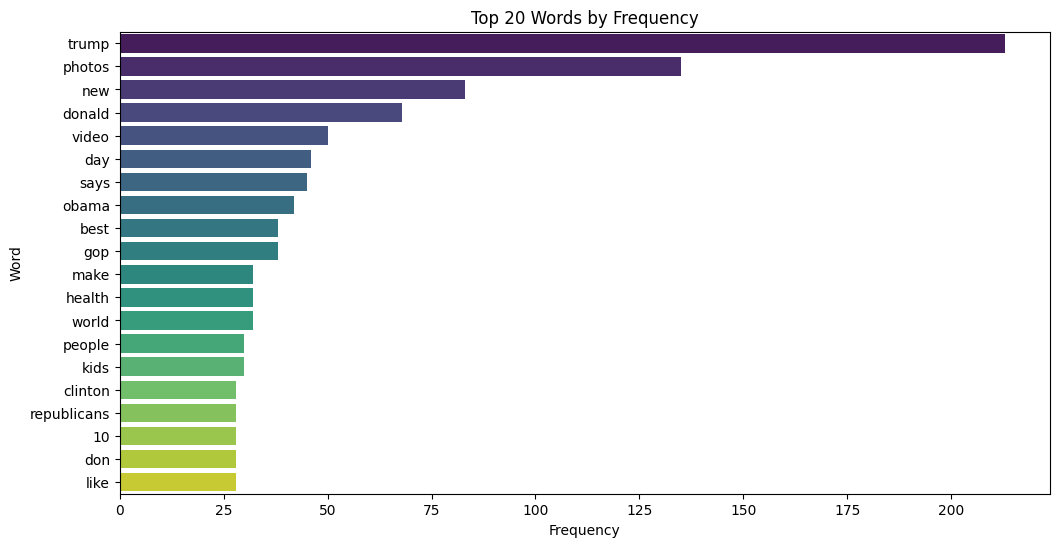

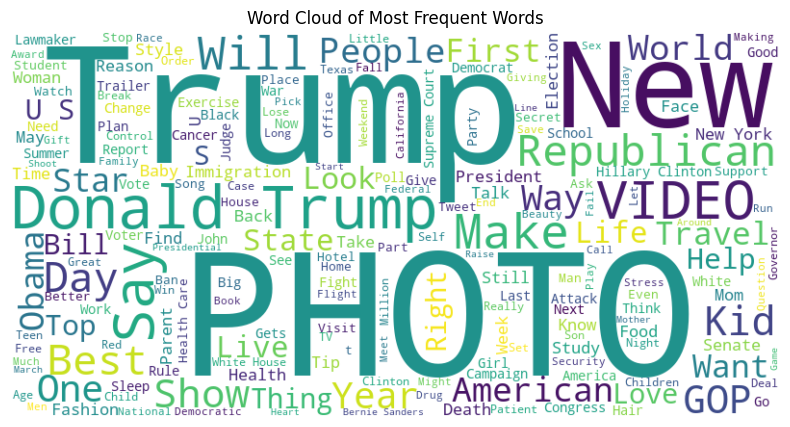

In [9]:
all_text = ' '.join(df['headline'].astype(str))

# Use CountVectorizer to get word frequencies
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
word_frequencies = vectorizer.fit_transform([all_text])

# Get the feature names (words) and their frequencies
words = vectorizer.get_feature_names_out()
frequencies = word_frequencies.sum(axis=0).A1

# Create a DataFrame with words and frequencies
word_df = pd.DataFrame({'Word': words, 'Frequency': frequencies})

# Sort the DataFrame by frequency in descending order
word_df = word_df.sort_values(by='Frequency', ascending=False)

# Display the top words
print("Top 10 words by frequency:")
print(word_df.head(10))

# Create a bar chart of the top words
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=word_df.head(20), palette='viridis')
plt.title('Top 20 Words by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

### Category wise word cloud

Top 5 words for category 'ENTERTAINMENT':
       Word  Frequency
84     star         20
60      new         18
92    trump         14
91  trailer         13
5      best          9
Top 5 words for category 'PARENTING':
       Word  Frequency
44     kids         20
3      baby         13
62  parents         13
51      mom         11
96    video         10
Top 5 words for category 'POLITICS':
      Word  Frequency
90   trump        199
29  donald         62
35     gop         38
58   obama         35
78    says         32
Top 5 words for category 'STYLE & BEAUTY':
       Word  Frequency
68   photos         87
30  fashion         21
88    video         21
93     week         17
67    photo         16
Top 5 words for category 'TRAVEL':
      Word  Frequency
66  photos         41
91  travel         21
9     best         15
98   world         13
0       10         12
Top 5 words for category 'WELLNESS':
      Word  Frequency
82   study         19
10  cancer         19
75   sleep         17
42

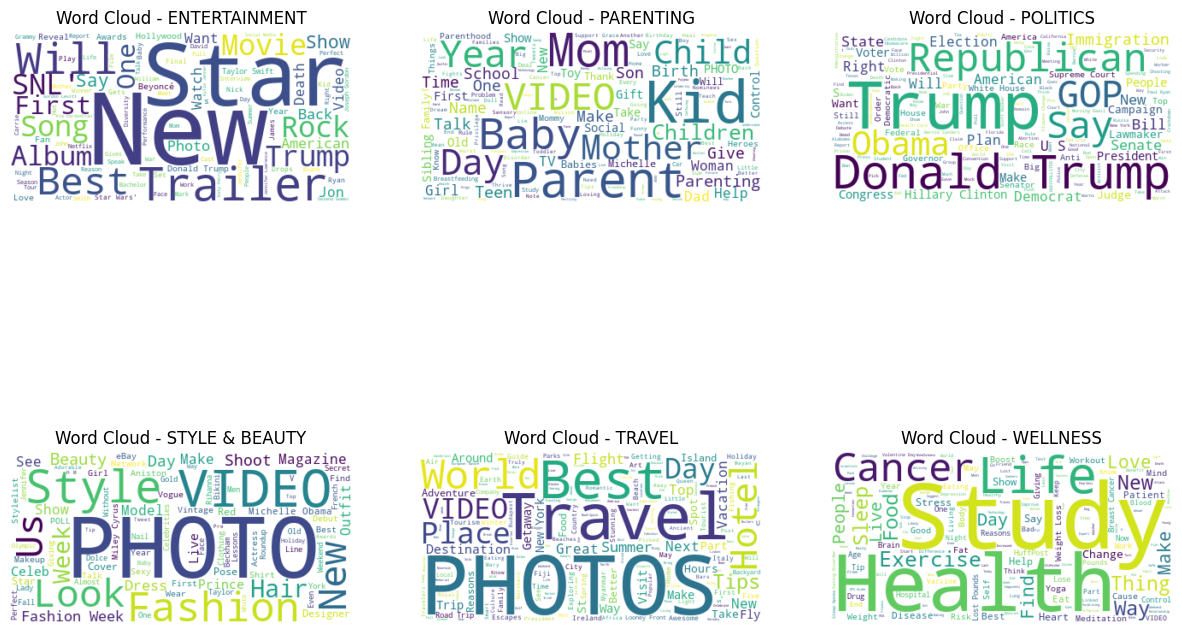

In [10]:
grouped_by_category = df.groupby('category')
# Combine all text data for each category into a single string
all_text_by_category = grouped_by_category['headline'].apply(lambda x: ' '.join(x.astype(str)))

# Calculate word frequencies for each category
wordclouds = {}
for category, text in all_text_by_category.items():
    vectorizer = CountVectorizer(stop_words='english', max_features=100)
    word_frequencies = vectorizer.fit_transform([text])
    words = vectorizer.get_feature_names_out()
    frequencies = word_frequencies.sum(axis=0).A1
    word_df = pd.DataFrame({'Word': words, 'Frequency': frequencies})
    word_df = word_df.sort_values(by='Frequency', ascending=False)
    
    # Display top words for each category
    print(f"Top 5 words for category '{category}':")
    print(word_df.head(5))
    
    # Create a word cloud for each category
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    wordclouds[category] = wordcloud

# Visualize word clouds for each category
plt.figure(figsize=(15, 10))
for i, (category, wordcloud) in enumerate(wordclouds.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {category}')
    plt.axis('off')
    # plt.tight_layout()
plt.show()


### Remove special characters, convert all to lower case and get rid of stop words

In [11]:
def remove_special_characters(text):
    # Define a pattern to match special characters (excluding alphanumeric characters and spaces)
    pattern = re.compile('[^A-Za-z0-9\s]')
    
    # Use the pattern to replace special characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text

# Apply the remove_special_characters function to the 'Text' column
df['headline'] = df['headline'].apply(remove_special_characters)
# df['authors'] = df['authors'].apply(remove_special_characters)

In [12]:
df['headline'] = df['headline'].str.lower()
# df['authors'] = df['authors'].str.lower()

In [13]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = text.split()  # Tokenize the text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the remove_stop_words function to the 'Text' column
df['headline'] = df['headline'].apply(remove_stop_words)
# df['authors'] = df['authors'].apply(remove_stop_words)

df.head(10)

,headline,category,date,text_length
0,dakota access protesters arrested deadline pas...,POLITICS,2017-02-22,67
1,summer sleepover tips,PARENTING,2012-07-25,21
2,end year,WELLNESS,2012-11-04,15
3,supermodel stephanie seymour sexy photo shootw...,STYLE & BEAUTY,2014-02-10,74
4,american attitudes guns become much positive,POLITICS,2017-07-27,70
5,carl bernstein way clinton email investigation...,POLITICS,2016-10-29,77
6,isnt charming way travel dont know,TRAVEL,2014-09-21,68
7,biden putin hold call stepped security demands,POLITICS,2021-12-29,58
8,anna dello russo hm hat practical everyday wea...,STYLE & BEAUTY,2012-10-22,78
9,trump get outside help potential gop conventio...,POLITICS,2016-05-01,61


### Lemmatization

In [14]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize text
def lemmatize_headline(text):
    words = word_tokenize(text)
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

# Apply lemmatization to the 'headline' column
df['headline'] = df['headline'].apply(lemmatize_headline)

# Display the result for the first few rows
print(df['headline'].head())


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    dakota access protester arrested deadline pass...
1                                 summer sleepover tip
2                                             end year
3    supermodel stephanie seymour sexy photo shootw...
4           american attitude gun become much positive
Name: headline, dtype: object


In [15]:
df.head(10)

,headline,category,date,text_length
0,dakota access protester arrested deadline pass...,POLITICS,2017-02-22,67
1,summer sleepover tip,PARENTING,2012-07-25,21
2,end year,WELLNESS,2012-11-04,15
3,supermodel stephanie seymour sexy photo shootw...,STYLE & BEAUTY,2014-02-10,74
4,american attitude gun become much positive,POLITICS,2017-07-27,70
5,carl bernstein way clinton email investigation...,POLITICS,2016-10-29,77
6,isnt charming way travel dont know,TRAVEL,2014-09-21,68
7,biden putin hold call stepped security demand,POLITICS,2021-12-29,58
8,anna dello russo hm hat practical everyday wea...,STYLE & BEAUTY,2012-10-22,78
9,trump get outside help potential gop conventio...,POLITICS,2016-05-01,61


### Saving this dataframe for use in future training and inference

In [18]:
# df.to_json('preprocessed_data.json', orient='records', lines=True)


### Testing of different models

I will try 4 approaches with random forest and naive bayes:
1) use vanilla rf and nb
2) Use oversampling
3) use dimensionality reduciton
4) use both over sampling and dimensionality reduction

#### Vanilla Random Forest and Naive Bayes

In [16]:
X = df['headline']
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Approach 1: Vanilla Random Forest (No oversampling or feature reduction)
vectorizer_rf = CountVectorizer()
X_train_rf = vectorizer_rf.fit_transform(X_train)
X_test_rf = vectorizer_rf.transform(X_test)

random_forest_model = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_val_score(random_forest_model, X_train_rf, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
random_forest_model.fit(X_train_rf, y_train)
y_pred_rf = random_forest_model.predict(X_test_rf)

print("Approach 1: Vanilla Random Forest")
print(f'Cross-Validation Accuracy: {cv_scores_rf.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}\n')

# Approach 2: Oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train.to_frame(), y_train)

vectorizer_oversampled = CountVectorizer()
X_train_oversampled = vectorizer_oversampled.fit_transform(X_train_oversampled['headline'])
X_test_oversampled = vectorizer_oversampled.transform(X_test)

random_forest_model_oversampled = RandomForestClassifier(random_state=42)
cv_scores_rf_oversampled = cross_val_score(random_forest_model_oversampled, X_train_oversampled, y_train_oversampled, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
random_forest_model_oversampled.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf_oversampled = random_forest_model_oversampled.predict(X_test_oversampled)

print("Approach 2: Random Forest with Oversampling")
print(f'Cross-Validation Accuracy: {cv_scores_rf_oversampled.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_rf_oversampled):.2f}\n')

# Approach 3: Feature Reduction
vectorizer_feature_reduction = CountVectorizer()
X_train_feature_reduction = vectorizer_feature_reduction.fit_transform(X_train)
X_test_feature_reduction = vectorizer_feature_reduction.transform(X_test)

selector = SelectKBest(f_classif, k=1000)
X_train_feature_reduction = selector.fit_transform(X_train_feature_reduction, y_train)
X_test_feature_reduction = selector.transform(X_test_feature_reduction)

random_forest_model_feature_reduction = RandomForestClassifier(random_state=42)
cv_scores_rf_feature_reduction = cross_val_score(random_forest_model_feature_reduction, X_train_feature_reduction, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
random_forest_model_feature_reduction.fit(X_train_feature_reduction, y_train)
y_pred_rf_feature_reduction = random_forest_model_feature_reduction.predict(X_test_feature_reduction)

print("Approach 3: Random Forest with Feature Reduction")
print(f'Cross-Validation Accuracy: {cv_scores_rf_feature_reduction.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_rf_feature_reduction):.2f}\n')

# Approach 4: Both Oversampling and Feature Reduction
oversampler_both = RandomOverSampler(random_state=42)
X_train_both, y_train_both = oversampler_both.fit_resample(X_train.to_frame(), y_train)

vectorizer_both = CountVectorizer()
X_train_both = vectorizer_both.fit_transform(X_train_both['headline'])
X_test_both = vectorizer_both.transform(X_test)

selector_both = SelectKBest(f_classif, k=1000)
X_train_both = selector_both.fit_transform(X_train_both, y_train_both)
X_test_both = selector_both.transform(X_test_both)

random_forest_model_both = RandomForestClassifier(random_state=42)
cv_scores_rf_both = cross_val_score(random_forest_model_both, X_train_both, y_train_both, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
random_forest_model_both.fit(X_train_both, y_train_both)
y_pred_rf_both = random_forest_model_both.predict(X_test_both)

print("Approach 4: Random Forest with Oversampling and Feature Reduction")
print(f'Cross-Validation Accuracy: {cv_scores_rf_both.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_rf_both):.2f}')


Approach 1: Vanilla Random Forest
Cross-Validation Accuracy: 0.61
Test Set Accuracy: 0.66

Approach 2: Random Forest with Oversampling
Cross-Validation Accuracy: 0.93
Test Set Accuracy: 0.65

Approach 3: Random Forest with Feature Reduction
Cross-Validation Accuracy: 0.64
Test Set Accuracy: 0.61

Approach 4: Random Forest with Oversampling and Feature Reduction
Cross-Validation Accuracy: 0.88
Test Set Accuracy: 0.65


In [17]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif

# Load your dataset (replace 'your_data.csv' with your actual file path)
# df = pd.read_csv('your_data.csv')

# Assuming 'headline' is the column containing news headlines and 'category' is the target variable
X = df['headline']
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Approach 1: Vanilla Naive Bayes (No oversampling or feature reduction)
vectorizer_nb = CountVectorizer()
X_train_nb = vectorizer_nb.fit_transform(X_train)
X_test_nb = vectorizer_nb.transform(X_test)

naive_bayes_model = MultinomialNB()
cv_scores_nb = cross_val_score(naive_bayes_model, X_train_nb, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
naive_bayes_model.fit(X_train_nb, y_train)
y_pred_nb = naive_bayes_model.predict(X_test_nb)

print("Approach 1: Vanilla Naive Bayes")
print(f'Cross-Validation Accuracy: {cv_scores_nb.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}\n')

# Approach 2: Oversampling
oversampler_nb = RandomOverSampler(random_state=42)
X_train_oversampled_nb, y_train_oversampled_nb = oversampler_nb.fit_resample(X_train.to_frame(), y_train)

vectorizer_oversampled_nb = CountVectorizer()
X_train_oversampled_nb = vectorizer_oversampled_nb.fit_transform(X_train_oversampled_nb['headline'])
X_test_oversampled_nb = vectorizer_oversampled_nb.transform(X_test)

naive_bayes_model_oversampled = MultinomialNB()
cv_scores_nb_oversampled = cross_val_score(naive_bayes_model_oversampled, X_train_oversampled_nb, y_train_oversampled_nb, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
naive_bayes_model_oversampled.fit(X_train_oversampled_nb, y_train_oversampled_nb)
y_pred_nb_oversampled = naive_bayes_model_oversampled.predict(X_test_oversampled_nb)

print("Approach 2: Naive Bayes with Oversampling")
print(f'Cross-Validation Accuracy: {cv_scores_nb_oversampled.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_nb_oversampled):.2f}\n')

# Approach 3: Feature Reduction
vectorizer_feature_reduction_nb = CountVectorizer()
X_train_feature_reduction_nb = vectorizer_feature_reduction_nb.fit_transform(X_train)
X_test_feature_reduction_nb = vectorizer_feature_reduction_nb.transform(X_test)

selector_nb = SelectKBest(f_classif, k=1000)
X_train_feature_reduction_nb = selector_nb.fit_transform(X_train_feature_reduction_nb, y_train)
X_test_feature_reduction_nb = selector_nb.transform(X_test_feature_reduction_nb)

naive_bayes_model_feature_reduction = MultinomialNB()
cv_scores_nb_feature_reduction = cross_val_score(naive_bayes_model_feature_reduction, X_train_feature_reduction_nb, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
naive_bayes_model_feature_reduction.fit(X_train_feature_reduction_nb, y_train)
y_pred_nb_feature_reduction = naive_bayes_model_feature_reduction.predict(X_test_feature_reduction_nb)

print("Approach 3: Naive Bayes with Feature Reduction")
print(f'Cross-Validation Accuracy: {cv_scores_nb_feature_reduction.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_nb_feature_reduction):.2f}\n')

# Approach 4: Both Oversampling and Feature Reduction
oversampler_both_nb = RandomOverSampler(random_state=42)
X_train_both_nb, y_train_both_nb = oversampler_both_nb.fit_resample(X_train.to_frame(), y_train)

vectorizer_both_nb = CountVectorizer()
X_train_both_nb = vectorizer_both_nb.fit_transform(X_train_both_nb['headline'])
X_test_both_nb = vectorizer_both_nb.transform(X_test)

selector_both_nb = SelectKBest(f_classif, k=1000)
X_train_both_nb = selector_both_nb.fit_transform(X_train_both_nb, y_train_both_nb)
X_test_both_nb = selector_both_nb.transform(X_test_both_nb)

naive_bayes_model_both = MultinomialNB()
cv_scores_nb_both = cross_val_score(naive_bayes_model_both, X_train_both_nb, y_train_both_nb, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
naive_bayes_model_both.fit(X_train_both_nb, y_train_both_nb)
y_pred_nb_both = naive_bayes_model_both.predict(X_test_both_nb)

print("Approach 4: Naive Bayes with Oversampling and Feature Reduction")
print(f'Cross-Validation Accuracy: {cv_scores_nb_both.mean():.2f}')
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred_nb_both):.2f}')


Approach 1: Vanilla Naive Bayes
Cross-Validation Accuracy: 0.71
Test Set Accuracy: 0.69

Approach 2: Naive Bayes with Oversampling
Cross-Validation Accuracy: 0.92
Test Set Accuracy: 0.71

Approach 3: Naive Bayes with Feature Reduction
Cross-Validation Accuracy: 0.72
Test Set Accuracy: 0.66

Approach 4: Naive Bayes with Oversampling and Feature Reduction
Cross-Validation Accuracy: 0.84
Test Set Accuracy: 0.66


#### **Naive Bayes with over sampling** has performed the best out of all the other models.
This might be because of the following reasons:
1. **Handling Class Imbalance:** Naive Bayes is known for being relatively robust to class imbalance. If the dataset has imbalanced classes, oversampling can help balance the class distribution, and Naive Bayes might perform well under these conditions.

2. **Sparse Data:** Naive Bayes can do well with sparsity in datasets or high-dimensional feature spaces. After conversion to bag of word representation, the dataset becomes quite sparse in this text application.

